In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from ranking_funcs import read_imdb_data,Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [6]:
def read_imdb_data(path):
    df = pd.read_csv(path)
    df['averageRating'] = round(df['averageRating'], 0)

    featlst = list(df.columns)

    for feat in featlst:
        l = df[feat]  

        if feat == 'isAdult':
            processed = [1 if v == 1 else 0 for v in l]
            df[feat] = processed

        if feat == 'runtimeMinutes':
            processed = [0 if v <= 23 else 1 if v <= 37 else 2 if v <= 47 else 3 for v in l]
            df[feat] = processed

        if feat == 'seasonNumber':
            processed = [0 if v <= 1 else 1 if v <= 2 else 2 if v <= 5 else 3 for v in l]
            df[feat] = processed

        if feat == 'episodeNumber':
            processed = [0 if v <= 4 else 1 if v <= 8 else 2 if v <= 15 else 3 for v in l]
            df[feat] = processed

        if feat == 'numVotes':
            processed = [0 if v <= 14 else 1 if v <= 35 else 2 if v <= 139 else 3 for v in l]
            df[feat] = processed

    return df



In [7]:
df=read_imdb_data('ranking_data_sets/cleaned_imdb.csv')
df.head()

,tconst,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
0,tt0041951,0,1,0,2,8.0,2
1,tt0044093,0,3,0,1,4.0,1
2,tt0045960,0,3,1,0,7.0,3
3,tt0046855,0,3,0,0,6.0,3
4,tt0047852,0,1,0,2,4.0,1


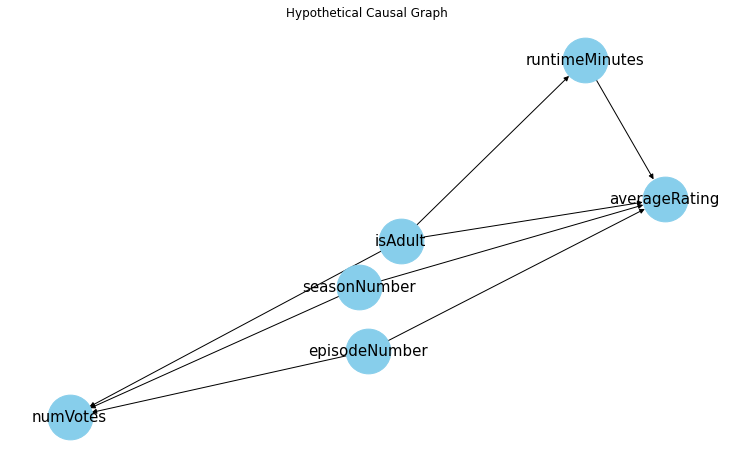

In [8]:
G = nx.DiGraph()

nodes = ["isAdult", "runtimeMinutes", "seasonNumber", "episodeNumber", "averageRating", "numVotes"]
G.add_nodes_from(nodes)


edges = [("isAdult", "runtimeMinutes"),
         ("isAdult", "averageRating"),
         ("isAdult", "numVotes"),
         ("runtimeMinutes", "averageRating"),
         ("seasonNumber", "averageRating"),
         ("seasonNumber", "numVotes"),
         ("episodeNumber", "averageRating"),
         ("episodeNumber", "numVotes")]
G.add_edges_from(edges)

plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)
plt.title("Hypothetical Causal Graph")
plt.show()

In [9]:
new_G=get_new_G(G,df)

In [11]:
## top 5 with no updates
df.sort_values(by='averageRating',ascending=False).head(5)

,tconst,isAdult,runtimeMinutes,seasonNumber,episodeNumber,averageRating,numVotes
279835,tt27879387,0,2,0,0,10.0,3
278297,tt27587460,0,1,0,3,10.0,0
59282,tt0649595,0,1,3,3,10.0,0
85983,tt0738675,0,3,3,0,10.0,3
277481,tt27424286,0,0,0,1,10.0,0


In [12]:
var=['runtimeMinutes']
df_gr=Greedy_Algo(new_G, df, 5, 'averageRating',var,0, {'seasonNumber':3},50, opt="add",force=0.5)
df_gr

,rank,prob,total_iters
0,"[3988, 4172, 5571, 9819, 3782]",0.7,35.0
1,"[3782, 3988, 4172, 5571, 9819]",0.3,15.0


In [13]:
most_probable_elements=get_most_probable_elements(df_gr)
most_probable_elements

,element,prob,total_iters
0,5571,1.0,50.0
1,3782,1.0,50.0
2,4172,1.0,50.0
3,3988,1.0,50.0
4,9819,1.0,50.0


In [15]:
row_indexes=[5571, 3782, 4172, 3988, 9819]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,0, {'seasonNumber':0},1, opt="add",force=0.5)

KeyboardInterrupt: 